Keras generators
---

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create image generator
train_generator = ImageDataGenerator(
    rescale=1/255, horizontal_flip=True, rotation_range=5, validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1/255)

We use the rescale parameter to normalize the images between zero and one, and the horizontal_flip and rotation_range transformations to get slightly different variants of the images each time we sample from the images to fight overfitting and virtually augment the data set to improve training. This is why we only use those parameters for the train_generator and not the test_generator one. Optionally, we can also keep a fraction of the data for validation. In this case, we keep 20% of the data as a validation set. Note that they will also go through the training transformations.

The second step is to create an iterator that iterates over the directory of CIFAR-10 .png images. The cifar10 folder can be downloaded from the resources of this unit. To iterate over the directory we can use the flow_from_directory() function from our image generators which takes the path to the directory, the batch size and the target size. This can be useful if we need to resize the images before inserting them into our network. However, in our case, we will keep the 32x32 .png images and set target_size=(32, 32)

In [2]:
import os

# Train, validation and test sets
trainset = train_generator.flow_from_directory(
    os.path.join('cifar10', 'train'), batch_size=32, target_size=(32, 32),
    shuffle=True, subset='training', class_mode = 'categorical') # 'sparse' if we want just the integer class
validset = train_generator.flow_from_directory(
    os.path.join('cifar10', 'train'), batch_size=32, target_size=(32, 32),
    shuffle=False, subset='validation', class_mode = 'categorical')
testset = test_generator.flow_from_directory(
    os.path.join('cifar10', 'test'), batch_size=32, target_size=(32, 32),
    shuffle=False, class_mode = 'categorical')

Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


We create a trainset and a validset iterator for the images from the train directory and a testset one for the images from the test directory. Note that we don't need to shuffle the validation and test data (i.e we set shuffle=False) since shuffling only affects training. Also, we only need to specify the subset argument for the train and validation sets since we used above the optional validation_split parameter from the train_generator.

We can always verify which images are assigned to each data set by looking at the filenames attribute

In [3]:
trainset.filenames[:5]

['airplane/airplane-101.png',
 'airplane/airplane-102.png',
 'airplane/airplane-103.png',
 'airplane/airplane-104.png',
 'airplane/airplane-105.png']

In [4]:
validset.filenames[:4]

['airplane/airplane-001.png',
 'airplane/airplane-002.png',
 'airplane/airplane-003.png',
 'airplane/airplane-004.png']

In [5]:
set(trainset.filenames).intersection(set(validset.filenames))

set()

As we can see, for each class the first 100 images (1000 validation images/10 class) were assigned to the validation set and the rest to the training one. We can verify that those two sets don't intersect with.

which returns an empty set for the intersection.

The directory iterators can be used like normal Python iterators ex. in a for loop. By calling next(), we get the next batch of images with their labels

In [6]:
batch_imgs, batch_labels = trainset.next()

print('Batch images:', batch_imgs.shape)
print('Batch labels:', batch_labels.shape)

Batch images: (32, 32, 32, 3)
Batch labels: (32, 10)


It's important to note that the iterator returns one-hot encoded labels by default. In our case, we have 10 classes, so batch_label is a 32x10 array

In [7]:
batch_labels[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [8]:
# get the original class name
trainset.class_indices

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

Note that it is possible to obtain integer encoded labels with the iterator. To do that, one can change the default parameter class_mode = 'categorical' in flow_from_directory() function to class_mode = 'sparse'

Training with generators
---

In [9]:
import tensorflow.keras as keras

# Convolutional Network
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2,
                              activation='relu', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=trainset.num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 44,362
Trainable params: 44,362
Non-trainable params: 0
_________________________________________________________________


Let's compile the model with the Adam optimizer and the categorical_crossentropy loss function which is equivalent to the sparse_categorical_crossentropy one from the last unit, but works with one-hot encoded labels

In [10]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

In [11]:
# End training when accuracy stops improving (optional)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

# Train model
history = model.fit_generator(
    generator=trainset, validation_data=validset, epochs=100, callbacks=[early_stopping])

Epoch 1/100
125/125 [==============================] - 4s 35ms/step - loss: 2.1525 - acc: 0.1988 - val_loss: 2.0324 - val_acc: 0.2530
Epoch 2/100
125/125 [==============================] - 4s 31ms/step - loss: 1.9256 - acc: 0.3038 - val_loss: 1.8645 - val_acc: 0.3180
Epoch 3/100
125/125 [==============================] - 4s 31ms/step - loss: 1.7791 - acc: 0.3535 - val_loss: 1.6813 - val_acc: 0.3890
Epoch 4/100
125/125 [==============================] - 4s 30ms/step - loss: 1.6820 - acc: 0.4037 - val_loss: 1.6565 - val_acc: 0.4060
Epoch 5/100
125/125 [==============================] - 4s 32ms/step - loss: 1.6205 - acc: 0.4222 - val_loss: 1.7154 - val_acc: 0.4000
Epoch 6/100
125/125 [==============================] - 4s 33ms/step - loss: 1.5553 - acc: 0.4435 - val_loss: 1.5831 - val_acc: 0.4310
Epoch 7/100
125/125 [==============================] - 4s 31ms/step - loss: 1.5099 - acc: 0.4733 - val_loss: 1.5161 - val_acc: 0.4630
Epoch 8/100
125/125 [==============================] - 4s 31ms

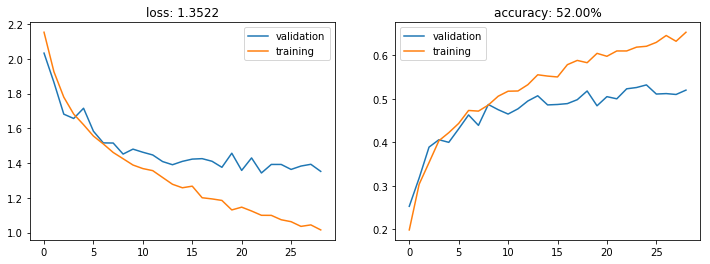

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history.history['val_loss'][-1]))
ax1.plot(history.history['val_loss'], label='validation')
ax1.plot(history.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history.history['val_acc'][-1]*100))
ax2.plot(history.history['val_acc'], label='validation')
ax2.plot(history.history['acc'], label='training')
ax2.legend()

plt.show()

Note that, unlike Scikit-learn library, Keras API can handle both integer encoded labels and one-hot encoded labels in order to perform multiclass classification. However, one needs to use the appropriate loss function: sparse_categorical_crossentropy for integer encoded labels and categorical_crossentropy for one-hot encoded labels.

Prediction and final test estimations
---

In [13]:
test_preds = model.predict_generator(testset)
print('Predictions:', test_preds.shape)

Predictions: (1000, 10)


In [14]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
matrix = confusion_matrix(
    y_true=testset.classes, # array with true labels
    y_pred=test_preds.argmax(axis=1) # array with predicted labels
)

# Format as a DataFrame
class_names = list(testset.class_indices.keys())
matrix_df = pd.DataFrame(data=matrix, columns=class_names, index=class_names)
matrix_df.columns.name = 'Predictions'
matrix_df.index.name = 'True class'
matrix_df

Predictions,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
True class,,,,,,,,,,
airplane,30,5,6,4,11,0,5,4,21,14
automobile,2,65,2,1,1,1,2,5,3,18
bird,4,1,26,15,20,9,13,5,2,5
cat,0,3,4,33,12,15,13,11,2,7
deer,0,2,6,9,41,7,13,17,1,4
dog,1,1,6,24,13,33,4,13,0,5
frog,0,0,2,8,5,3,76,1,0,5
horse,0,0,3,11,9,3,1,70,1,2
ship,13,11,0,3,2,2,2,3,57,7


In [15]:
test_loss, test_acurracy = model.evaluate_generator(testset)
print('Test loss: {:.2f}, accuracy: {:.2f}%'.format(test_loss, test_acurracy*100))

Test loss: 1.45, accuracy: 50.20%


__Why dividing by 255 is better than standardization__ 
The goal of scaling is to make all features (i.e. here the values for the pixels) comparable between each other and to bring it to a range somewhere around 0 (here between 0 and 1). We know that images are stored in integer values between 0 and 255, so dividing them by 255 will make all features map to the same space between 0 and 1. In contrast to this, using a scaler like StandardScaler()will scale each feature (i.e. pixel) individually, i.e. based on the value distribution at a given voxel location. Now, in a strange case, where for example all of your images have dark corners, the standard deviation for these images would be smaller than the centers and therefore the StandardScaler would amplify them. This could eventually lead to an unwanted bias.

__How to use StandardScaler() with TensorFlow__ 
Using some custom layers, it would be possible to use Scikit-Learn's StandardScaler within the TensorFlow framework. At least I assume so. But what is important to know here is the following: TensorFlow is super efficient because they use a slightly augmented version of data arrays. It's similar to numpy arrays but even more optimized. In the context of TensorFlow, they are called Tensor Arrays. Scikit-Learn's StandardScaler wouldn't know how to handle them, and using StandardScaler within Tensorflow would force the framework to transform the data first into numpy array, and as such loose precious time. So instead of trying to force a different framework into Tensorflow, an alternative is to use a Tensorflow functionality, like the normalization layer or to just normalize the data before feeding it into the model.